# Crack Detection Training


### Requirements >= Tensorflow-2.9

### This notebook is designed for model training . It is recommended to not execute the cells and just parse through the notebook to prevent retraining . The notebook crackModelTestX.ipynb is to be executed cell wise to verify the judging metrics .

### A precision of 1.0 , recall score of 1.0 and f1-score of 1.0 has been obtained from the model training. It can be verified from the crackModelTest.ipynb 

#### THE MODEL CAN BE VERIFED IN THIS NOTEBOOK ITSELF FROM "LOADING THE MODEL CONFIGURATION CELL". A 

#### SEPERATE TESTING FILE HAS BEEN CREATED FOR CLARITY

In [1]:
import glob
from os import path
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model
from keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics

import pickle


2023-01-14 21:05:30.657952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 21:05:30.781687: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 21:05:30.781706: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-14 21:05:31.273751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Importing and preprocessing of images

#### 300 positive train images 224\*224*3

#### 300 negative train images 224\*224*3

#### 100 positive test images 224\*224*3

#### 100 negaitive test images 224\*224*3

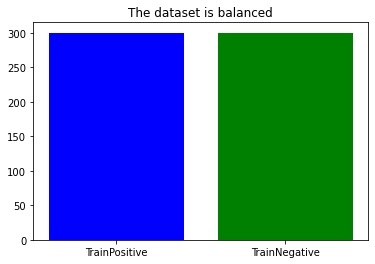

In [7]:
# importing train and test images 

positive_train_path = "./train/Positive"

negative_train_path = "./train/Negative"

positive_test_path = "./test/Positive"

negative_test_path = "./test/Negative"

positive_validate_path = "./valid/Positive"

negative_validate_path = "./valid/Negative"


#Calculating Image Paths

positive_train_fp = glob.glob(path.join(positive_train_path,'*.jpg'))

negative_train_fp = glob.glob(path.join(negative_train_path,'*.jpg'))

positive_test_fp = glob.glob(path.join(positive_test_path,'*.jpg'))

negative_test_fp = glob.glob(path.join(negative_test_path,'*.jpg'))

positive_validate_fp = glob.glob(path.join(positive_validate_path,'*.jpg'))

negative_validate_fp = glob.glob(path.join(negative_validate_path,'*.jpg'))


#Loading images

positive_train_images = np.asarray([img_to_array(load_img(path)) for path in positive_train_fp ])

negative_train_images = np.asarray([img_to_array(load_img(path)) for path in negative_train_fp ])

positive_test_images = np.asarray([img_to_array(load_img(path)) for path in positive_test_fp ])

negative_test_images = np.asarray([img_to_array(load_img(path)) for path in negative_test_fp ])

positive_validate_images = np.asarray([img_to_array(load_img(path)) for path in positive_test_fp ])

negative_validate_images = np.asarray([img_to_array(load_img(path)) for path in negative_test_fp ])


#combining images

train_images = np.concatenate((positive_train_images , negative_train_images),axis=0)

test_images = np.concatenate((positive_test_images , negative_test_images),axis=0)

validation_images = np.concatenate((positive_validate_images , negative_validate_images),axis=0)

# Normalizing image data (divide by 255)

train_images = train_images/255

test_images = test_images/255

validation_images = validation_images/255



plt.bar(['TrainPositive','TrainNegative'],[len(positive_train_images),len(negative_train_images)],color=['b','g'])
plt.title("The dataset is balanced")
plt.show()

### Generating labels 1 (Positive) and 0 (Negative)

In [59]:
# Generating labels

# train labels

positive_train_labels = np.ones(300)

negative_train_labels = np.zeros(300)

train_labels = np.hstack((positive_train_labels,negative_train_labels))

# test labels

positive_test_labels = np.ones(100)

negative_test_labels = np.zeros(100)

test_labels = np.hstack((positive_test_labels,negative_test_labels))

# validation labels

positive_validation_labels = np.ones(100)

negative_validation_labels = np.zeros(100)

validation_labels = np.hstack((positive_test_labels,negative_test_labels))

### using ImageDatagenerator to create augmented images on the fly as the dataset contains only 600 images

#### commented to prevent  further alterations

In [24]:
'''
datagenX = ImageDataGenerator(featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,  
    brightness_range=[0.2,0.8])

datagenX.fit(train_images)

'''

#### Imporitng keras modules and classes

In [23]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Dense,BatchNormalization,GlobalAveragePooling2D
from keras.layers import Activation,Flatten

### Defining the CNN DeepLearning Framework

In [25]:
def crackDetectionModel(nLayers):
    
    MIN_NEURONS = 53
    MAX_NEURONS = 253
    KERNEL = (5,3)
    
    steps = np.floor(MAX_NEURONS/(nLayers+1))
    neurons = np.arange(MIN_NEURONS,MAX_NEURONS,steps)
    neurons = neurons.astype(np.int32)
    
    model = Sequential()
    #model.add(pretrained_eB7)
    for i in range(nLayers-1):
        if i == 0:
            
            model.add(Conv2D(neurons[i],padding="same", kernel_size=KERNEL,input_shape=(224,224,3)))
            model.add(Activation('relu'))
        elif i%3 == 0 :
            model.add(Conv2D(neurons[i],padding="same",kernel_size=KERNEL,kernel_initializer='he_normal'))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
        else:
            model.add(Conv2D(neurons[i],KERNEL,padding="same"))
            model.add(BatchNormalization())
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Flatten())
    
    model.add(Dense(53,activation = 'relu',kernel_initializer='he_normal'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    adam =  optimizers.Adam(learning_rate=.001)
    
    model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
    
    return model

modelX = crackDetectionModel(13)

## Training

### 1st iteration with epoch 291 and batch size 23 ---- dataGenerator used (for learning the granularity of cracked images)

### 2nd iteration with epoch 353 and batch size 53

### 3rd iteration with epoch 3 and batch size 13

    Note : model.fit methods have been commented to prevent retraining . Training has been done and the model           architecture has been saved in the 'model_archX' directory which has been used in crackModelTestX.ipynb' notebook

### 1'st iteration

#### commented to prevent  further alterations

In [ ]:
'''

#Epochs

epochs = 291

# Batch size

batch_size = 23


historyX = modelX.fit(datagenX.flow(train_images,train_labels,
                                       batch_size=batch_size, 
                                       seed=53,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=train_images.shape[0]//batch_size,
                    validation_data=(validation_images,validation_labels),
                    verbose=1)
                
'''

### 2'nd iteration

#### commented to prevent  further alterations

In [ ]:
'''

historyX = modelX.fit(train_images,train_labels,
                    epochs=353,
                    batch_size=53,
                    validation_data=(validation_images,validation_labels),
                    verbose=1)
                    
                    
'''

### 3'rd iteration 

#### commented to prevent  further alterations

In [ ]:
''''


historyX = modelX.fit(train_images,train_labels,
                    epochs=3,
                    batch_size=13,
                    validation_data=(validation_images,validation_labels),
                    verbose=1)
                    
'''

### Saving the model architecture : To be used in Testing notebook . Saved twice for redundancy.


#### commented to prevent  further alterations

In [30]:
#modelX.save('./round_3')
#modelX.save('./model_archX')


INFO:tensorflow:Assets written to: ./round_3/assets


INFO:tensorflow:Assets written to: ./round_3/assets


INFO:tensorflow:Assets written to: ./model_archX/assets


INFO:tensorflow:Assets written to: ./model_archX/assets


### Loading the model configuration

In [56]:
modelX = load_model('./round_3')
modelX.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, None, None, 53)    1007      
                                                                 
 activation_13 (Activation)  (None, None, None, 53)    0         
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 71)    22649     
                                                                 
 batch_normalization_8 (Batc  (None, None, None, 71)   284       
 hNormalization)                                                 
                                                                 
 activation_14 (Activation)  (None, None, None, 71)    0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, None, None, 71)   0         
 g2D)                                                 

### Predicting test images

In [57]:
image_pred = modelX.predict(test_images)

image_pred = np.round(image_pred)

7/7 [==============================] - 3s 410ms/step


### Judging Metrics

In [58]:
print("Precision : ",metrics.precision_score(test_labels,image_pred))
print("Recall : ",metrics.recall_score(test_labels,image_pred))
print("F1-score : ",metrics.f1_score(test_labels,image_pred))

Precision :  1.0
Recall :  1.0
F1-score :  1.0


### Graphical Representation of Training History

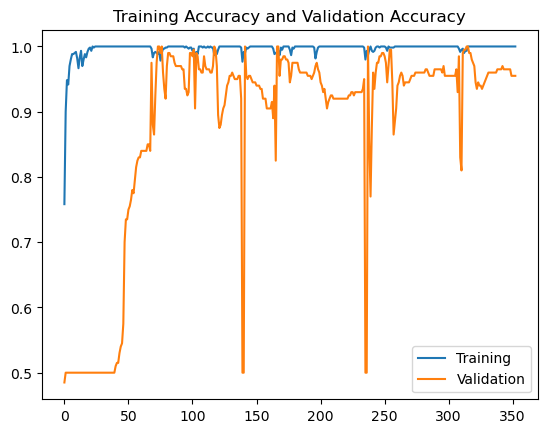

In [2]:
with open("trainHistoryDict",'rb') as f :
    history = pickle.load(f)

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['Training' , 'Validation'])
plt.title("Training Accuracy and Validation Accuracy")
plt.show()